In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Get "must import comet first" bug otherwise.
from img_wang.callbacks import CometCallbackWithGrads

/Users/hmamin/anaconda3/lib/python3.7/site-packages/incendio/callbacks.py:25: UserWarning: Accio not available.
  warnings.warn('Accio not available.')


In [106]:
from fastai2.data.transforms import get_image_files
from fastai2.vision.all import show_image, show_images
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from htools import *
from img_wang.data import load_img, get_databunch
from img_wang.models import Encoder, SingleInputBinaryModel, \
    TorchvisionEncoder
from incendio.callbacks import MetricHistory
from incendio.core import Trainer
from incendio.metrics import mean_soft_prediction, percent_positive

In [107]:
cd_root()

Current directory: /Users/hmamin/img_wang


## Scratch

In [306]:
# Slightly more polished version in lib. Use that instead.

# Maybe later add some transform (rotate, affine, noise, etc.) so it's not
# a perfect duplicate. But for now we've had trouble getting even easy tasks
# to work so I think it's a fine place to start.
class PatchworkDS(Dataset):
    
    def __init__(self, dir_=None, paths=(), shape=(128, 128), n=3, 
                 patch_shape=(48, 48), **kwargs):
        if not dir_ and not paths:
            raise ValueError('One of dir_ or paths should be non-null.')
            
        self.paths = paths or get_image_files(dir_)
        self.n = n
        self.load_img = partial(load_img, shape=shape)
        self.shape = shape
        self.patch_h, self.patch_w = patch_shape
        self.max_top = shape[0] - self.patch_h
        self.max_left = shape[1] - self.patch_w
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, i):
        """
        1 if patch is from the original image, 0 otherwise.
        """
        img = self.load_img(self.paths[i])
        src_coords = self.sample_coords()
        if np.random.uniform() > 0.5:
            img2 = torch.tensor(img)
            targ_coords = self.sample_coords()
            y = 1
        else:
            i2 = i
            while i2 == i:
                i2 = np.random.choice(len(self))
            img2 = self.load_img(self.paths[i2])
            targ_coords = src_coords
            y = 0
        
        img[targ_coords] = img2[src_coords]
        return img, torch.tensor(y)
    
    def sample_coords(self):
        left_x = np.random.randint(0, self.max_left)
        top_y = np.random.randint(0, self.max_top)
        return (slice(None), 
                slice(top_y, top_y+self.patch_h), 
                slice(left_x, left_x+self.patch_w))

In [307]:
ds = PatchworkDS('data/imagewang-160/unsup/')

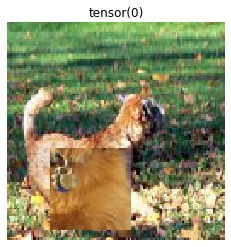

In [309]:
x, y = ds[4]
show_image(x, title=y)

In [310]:
dl = DataLoader(ds, batch_size=4, shuffle=False)

In [311]:
it = iter(dl)
xb, yb = next(it)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


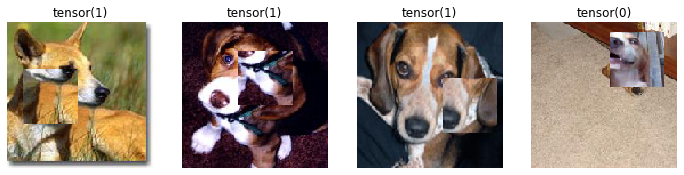

In [312]:
show_images(xb, titles=yb)

## Cleaned up and ported DS

In [149]:
dst, dsv, dlt, dlv = get_databunch('data/imagewang-160/unsup/', 
                                   mode='patchwork', bs=2, max_train_len=2,
                                   max_val_len=2, pct_pos=1, 
                                   debug_mode='fixed')

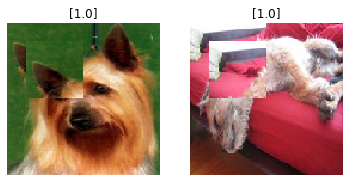

In [150]:
xb, yb = next(iter(dlt))
show_images(xb, titles=yb.tolist())

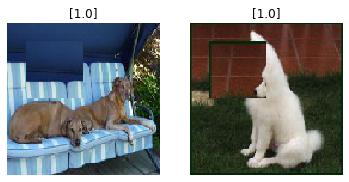

In [151]:
xv, yv = next(iter(dlv))
show_images(xv, titles=yv.tolist())

In [160]:
# net = SingleInputBinaryModel()
net = SingleInputBinaryModel(TorchvisionEncoder())

In [161]:
net.groups[0].freeze()

2020-09-07 14:55:15,051 [INFO]: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 0.001
    lr: 0.001
    weight_decay: 0
)


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/hdmamin/img-wang/dfef22da9f0c497990258080cf571a56





=====

Epoch 0

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.2773 |       0.0272 |
| mean_soft_prediction |  0.7578 |       0.9733 |
| percent_positive     |  1.0000 |       1.0000 |





=====

Epoch 1

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0106 |       0.0029 |
| mean_soft_prediction |  0.9894 |       0.9971 |
| percent_positive     |  1.0000 |       1.0000 |





=====

Epoch 2

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0010 |       0.0005 |
| mean_soft_prediction |  0.9990 |       0.9995 |
| percent_positive     |  1.0000 |       1.0000 |





=====

Epoch 3

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0002 |       0.0001 |
| mean_soft_prediction |  0.9998 |       0.9999 |
| percent_positive     |  1.0000 |       1.0000 |





=====

Epoch 4

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0000 |       0.0000 |
| mean_soft_prediction |  1.0000 |       1.0000 |
| percent_positive     |  1.0000 |       1.0000 |





=====

Epoch 5

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0000 |       0.0000 |
| mean_soft_prediction |  1.0000 |       1.0000 |
| percent_positive     |  1.0000 |       1.0000 |





=====

Epoch 6

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0000 |       0.0000 |
| mean_soft_prediction |  1.0000 |       1.0000 |
| percent_positive     |  1.0000 |       1.0000 |





=====

Epoch 7

| Metric               |   Train |   Validation |
|----------------------|---------|--------------|
| loss                 |  0.0000 |       0.0000 |
| mean_soft_prediction |  1.0000 |       1.0000 |
| percent_positive     |  1.0000 |       1.0000 |


Training complete. Model in eval mode.


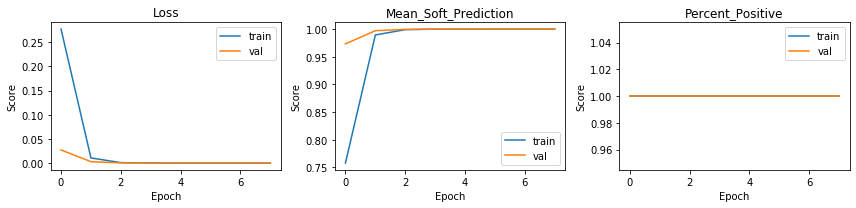

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/hdmamin/img-wang/dfef22da9f0c497990258080cf571a56
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss                           : 0.2773168683052063
COMET INFO:     train_loss [8]                 : (1.4305101103673223e-06, 0.2773168683052063)
COMET INFO:     train_mean_soft_prediction [8] : (0.7578351497650146, 0.9999985694885254)
COMET INFO:     train_percent_positive [8]     : 1.0
COMET INFO:     val_loss [8]                   : (4.768369876728684e-07, 0.027239130809903145)
COMET INFO:     val_mean_soft_prediction [8]   : (0.9732673764228821, 0.9999995231628418)
COMET INFO:     val_percent_positive [8]       : 1.0
COMET INFO:   Parameters:
COMET INFO:     _stop_training : 1
COMET INFO:     epochs         : 8
COMET INFO:     eps       

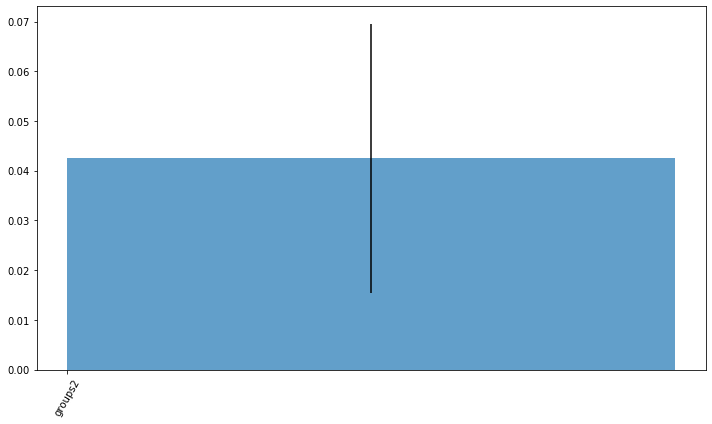

In [162]:
t = Trainer(net, dst, dsv, dlt, dlv, F.binary_cross_entropy_with_logits,
            mode='binary', out_dir='data/models/v0', last_act=torch.sigmoid,
            callbacks=[MetricHistory(None, None),
                       CometCallbackWithGrads('img_wang')],
            metrics=[mean_soft_prediction, percent_positive])
t.fit(8, 1e-3)

In [163]:
t.predict(xb, logits=False)

tensor([[1.0000],
        [1.0000]])

In [164]:
t.predict(xb)

tensor([[14.4363],
        [10.1968]])

In [165]:
yb

tensor([[1.],
        [1.]])

In [166]:
t.predict(xv, logits=False)

tensor([[1.0000],
        [1.0000]])

In [167]:
yv

tensor([[1.],
        [1.]])